<a href="https://colab.research.google.com/github/marcelogarret/rna/blob/main/MLP_backpropagation_garret_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

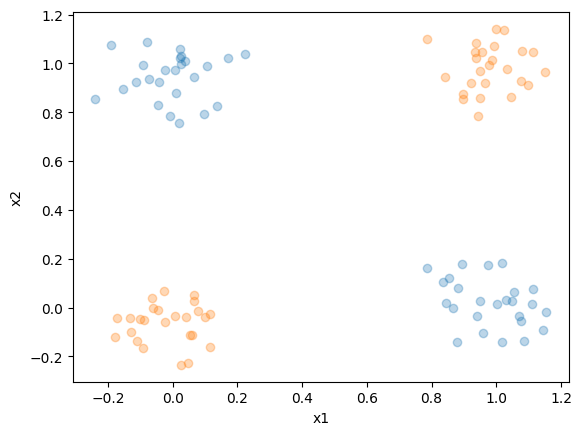

In [58]:
import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score
from scipy.special import expit

def tanh(a):
  return expit(a) * 2 - 1

def sign(a):
  return (a>0) * 2 - 1

def criaDataset(n=100, func=lambda a, b: bool(a) != bool(b)):
  X, y = make_blobs(n_samples=n, centers=[[0,0], [1,0], [1,1], [0,1]], cluster_std=0.1)
  y = sign(np.array([func(x[0]>0.5, x[1]>0.5) for x in X], dtype=int))
  return X, y

def plotDataset(X, y):
  plt.xlabel("x1")
  plt.ylabel("x2")
  for k in set(y):
    plt.plot(X[:,0][y==k], X[:,1][y==k], "o", alpha=0.3)

def defineAxes(X):
  offset = 0.5
  min1, max1 = X[:, 0].min(), X[:, 0].max()
  min2, max2 = X[:, 1].min(), X[:, 1].max()
  return [min1 - offset, max1 + offset, min2 - offset, max2 + offset]

def plotPredictions(clf, X):
  axes = defineAxes(X)
  x0s = np.linspace(axes[0], axes[1], 100)
  x1s = np.linspace(axes[2], axes[3], 100)
  x0, x1 = np.meshgrid(x0s, x1s)
  X = np.c_[x0.ravel(), x1.ravel()]
  y_pred = clf.predict(X).reshape(x0.shape)
  plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.3)

def include_bias(X):
  bias = np.ones((X.shape[0], 1))
  Xb = np.concatenate((bias, X), axis=1)
  return Xb

X, y = criaDataset()
plotDataset(X, y)

1.0


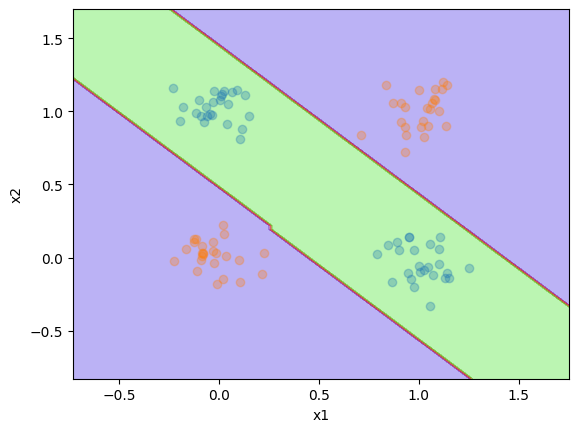

In [59]:
class Backpropagation(BaseEstimator, ClassifierMixin):
  def __init__(self, max_iter=1000, learning_rate=0.005, n_hidden=[2], activations=[tanh]):
    self.w = None
    self.max_iter = max_iter
    self.learning_rate = learning_rate
    self.n_hidden = n_hidden
    self.activations = activations

  def forward(self, X):
    self.A = []
    self.Z = []
    AUX = X.copy()
    for i, W in enumerate(self.Ws):
      self.A.append(include_bias(AUX))
      self.Z.append(self.A[-1] @ W)
      activation = self.activations[min(i, len(self.activations) - 1)]
      AUX = activation(self.Z[-1])
    return AUX

  def backward(self, X, y, ypred):
    grads = []
    output_delta = y.reshape(-1,1) - ypred.reshape(-1,1)
    grads.insert(0, self.A[-1].T @ output_delta)
    for i in range(len(self.Ws)-1, 0, -1):
      activation = self.activations[min(i, len(self.activations) - 1)]
      tanh_grad = (1 - np.square(activation(self.Z[i-1])))
      input_delta = (output_delta @ self.Ws[i][1:,:].T) * tanh_grad
      grads.insert(0, self.A[i-1].T @ input_delta)
      output_delta = input_delta.copy()
    for i in range(len(self.Ws)-1, -1, -1):
      self.Ws[i] += grads[i] * self.learning_rate

  def fit(self, X, y):
    self.Ws = []
    previous_output = X.shape[1]
    for layer_size in self.n_hidden:
      self.Ws.append(np.random.uniform(-1, 1, size=(previous_output+1, layer_size)))
      previous_output = self.Ws[-1].shape[1]
    self.Ws.append(np.random.uniform(-1, 1, size=(previous_output+1, 1)))
    for _ in range(self.max_iter):
      ypred = self.forward(X)
      self.backward(X, y, ypred)

  def predict(self, X):
    return sign(self.forward(X))

X, y = criaDataset()
plotDataset(X, y)
clf = Backpropagation()
clf.fit(X, y)
plotPredictions(clf, X)
ypred = clf.predict(X)
print(accuracy_score(y, ypred))

0.8


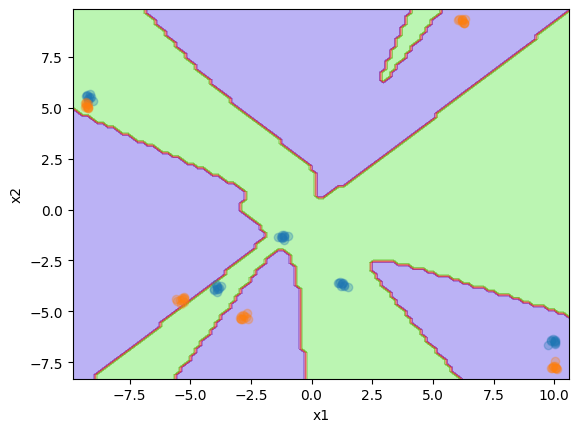

In [60]:
def criaDatasetDificil(n=100, centros=10):
  X, y = make_blobs(n_samples=n, centers=centros, cluster_std=0.1)
  y = sign(np.array(y%2, dtype=int))
  return X, y

X, y = criaDatasetDificil(centros=10)
plotDataset(X, y)
clf = Backpropagation(n_hidden=[20, 10], activations=[tanh, tanh])
clf.fit(X, y)
plotPredictions(clf, X)
ypred = clf.predict(X)
print(accuracy_score(y, ypred))

Backpropagation accuracy: 0.95
Sklearn accuracy: 1.0


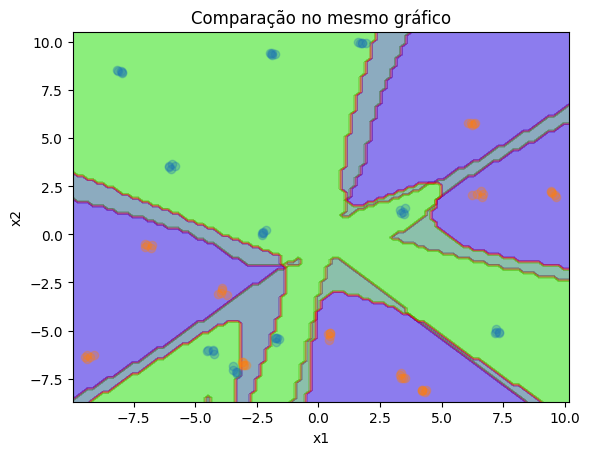

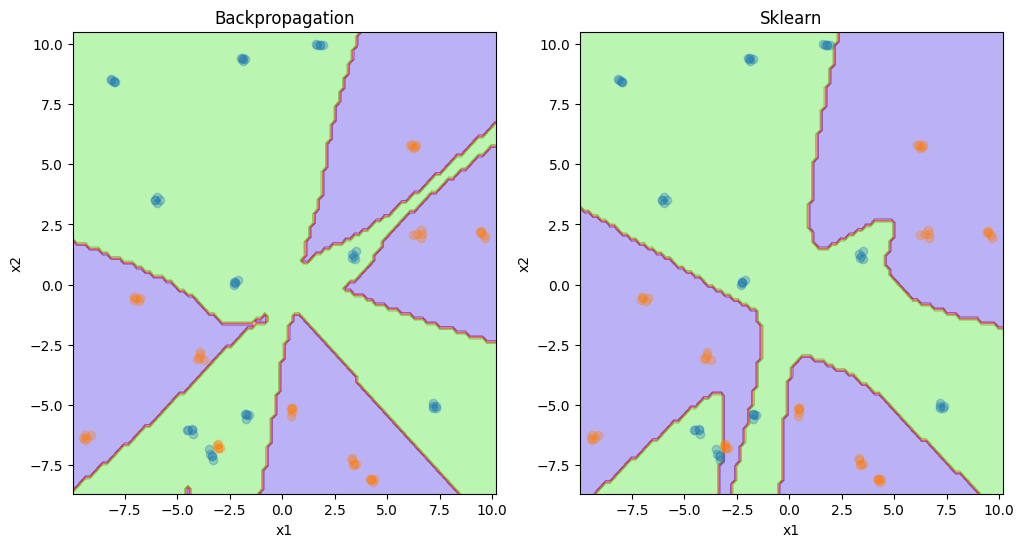

In [61]:
### Comparação com o sklearn ###

from sklearn.neural_network import MLPClassifier

X, y = criaDatasetDificil(centros=20)

# Configuração inicial e treinamento do modelo Backpropagation
clf = Backpropagation(max_iter=1000, learning_rate=0.005, n_hidden=[20, 10], activations=[tanh, tanh])
clf.fit(X, y)
plotDataset(X, y)
plotPredictions(clf, X)
ypred_custom = clf.predict(X)
plt.title('Comparação no mesmo gráfico')
print("Backpropagation accuracy:", accuracy_score(y, ypred_custom))

# Treinamento e avaliação do modelo MLPClassifier do sklearn
clf_sklearn = MLPClassifier(hidden_layer_sizes=(20, 10), activation='tanh', max_iter=1000, learning_rate_init=0.005)
clf_sklearn.fit(X, y)
plotPredictions(clf_sklearn, X)
ypred_sklearn = clf_sklearn.predict(X)
print("Sklearn accuracy:", accuracy_score(y, ypred_sklearn))

# Exibindo as previsões dos dois modelos no mesmo gráfico para comparação visual
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plotDataset(X, y)
plotPredictions(clf, X)
plt.title('Backpropagation')

plt.subplot(1, 2, 2)
plotDataset(X, y)
plotPredictions(clf_sklearn, X)
plt.title('Sklearn')
plt.show()